In [12]:
import tensorflow as tf
#from tensorflow.keras.layers import LayerNormalization
print(tf.__version__)
import keras
import keras.utils
from keras import utils as np_utils
from matplotlib import pyplot
from keras.utils import to_categorical
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Print shape to verify
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Normalize the image data to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

import warnings

if not tf.test.gpu_device_name():
    warnings.warn('No GPU Found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2.10.1
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)
Default GPU Device: /device:GPU:0


2024-06-07 13:58:29.887009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9640 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-06-07 13:58:29.887373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9640 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-06-07 13:58:29.887678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 9640 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2024-06-07 13:58:29.888152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:3 with 9640 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:d9:00.0, compute capability: 7.5
2024-06-07 13:58:29.893204: I tensorflow/core/common_runtime/gpu

In [13]:
'''
This code block is using Keras' ImageDataGenerator class to perform real-time data augmentation on the CIFAR-10 dataset.
Data augmentation is a technique used to increase the diversity of training data by applying random transformations to the existing images. 
This helps improve the model's ability to generalize and reduces the risk of overfitting.
'''
from keras.preprocessing.image import ImageDataGenerator


print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
          featurewise_center=False,           # set input mean to 0 over the dataset
          samplewise_center=False,            # set each sample mean to 0
          featurewise_std_normalization=False,# divide inputs by std of the dataset
          samplewise_std_normalization=False, # divide each input by its std
          zca_whitening=False,                # apply ZCA whitening
          rotation_range=0,                   # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,              # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,             # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,               # randomly flip images
          vertical_flip=False )               # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
#datagen.fit( x_test )

Using real-time data augmentation.


In [14]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-06-07 13:58:30.863272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9640 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-06-07 13:58:30.863637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9640 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-06-07 13:58:30.863957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9640 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2024-06-07 13:58:30.864296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9640 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [15]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(trainImages, trainLabels), (testImages, testLabels) = cifar10.load_data()
# one hot encode target values
trainLabels = to_categorical(trainLabels)
testLabels = to_categorical(testLabels)

# normalize to range 0-1
train_Images = trainImages / 255.0
test_Images = testImages / 255.0
trainImages, valImages, trainLabels, valLabels = train_test_split(trainImages, trainLabels, test_size=0.1)

In [17]:
def stem_block(x):
    
    a = Conv2D(kernel_size=3,filters=32, strides=1, padding='same')(x)
    a = BatchNormalization()(a)
    a = Activation('elu')(a)
    
    branch1 = Conv2D(kernel_size=1,filters=16, strides=1,  padding='valid')(a) #, kernel_regularizer=l2(0.0001)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('elu')(branch1)
    
    branch1 = Conv2D(kernel_size=3,filters=32, strides=1, padding='same', kernel_regularizer=l2(0.0001))(branch1) 
    #branch1 = DepthwiseConv2D((3, 3), padding='same', strides=1)(branch1) 
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('elu')(branch1)
    
    branch2 = MaxPooling2D(1)(a)
    
    x = Concatenate()([branch1, branch2])
    
    y = Conv2D(kernel_size=1,filters=32, strides=1,  padding='valid', kernel_regularizer=l2(0.0001))(x) #, kernel_regularizer=l2(0.0001)
    y = BatchNormalization()(y)
    y = Activation('elu')(y)
    
    return y



In [18]:
def bn_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding = 'same', kernel_regularizer=l2(0.0001))(x)    #, kernel_regularizer=l2(0.0001)
    x = BatchNormalization()(x)
    x = ELU()(x)
    return x
'''
This function defines a depthwise separable convolutional layer with batch normalization and ELU activation.'''
def depthconv_bn_relu(x, filters, kernel_size):
    x = DepthwiseConv2D(kernel_size=3, padding='same', kernel_regularizer=l2(0.0001))(x) #, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01)
    x = BatchNormalization(momentum=0.9,epsilon=0.00001)(x)
    x = ELU()(x)
    return x
'''This function defines a dense block, which is a building block of the DenseNet architecture.'''
def dense_block(tensor, k, reps):  # k = number of filters dense block will use. #tensor=input tensor, reps=repetitions
    for _ in range(reps):
        x = bn_relu_conv(tensor, k, 1)  # denseNet says, (1x1)conv mul. by 4.
        x = depthconv_bn_relu(x, k, kernel_size=3)  # x=input, k= filters, kernel_size=3
        tensor = Concatenate()([tensor, x])
    return tensor

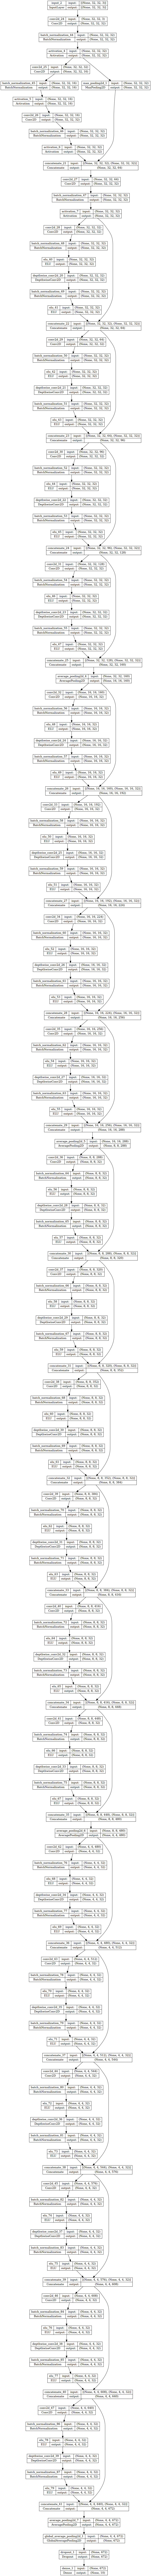

In [19]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAvgPool2D, DepthwiseConv2D, Concatenate, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, \
     Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, \
     MaxPool2D, GlobalAvgPool2D, Reshape, Permute, Lambda,  ZeroPadding2D, ELU, Dropout

k = 32 
n_dense_layers = [4, 4, 6, 6]
repetitions = 4, 4, 6, 6
input_shape=(32,32,3)
input = Input(input_shape)
x = stem_block(input)
Conv1_1 = dense_block(x, k, n_dense_layers[0])
Conv1_2 = AvgPool2D(2, strides=2, padding = 'same')(Conv1_1)

Conv2_1 = dense_block(Conv1_2, k,  n_dense_layers[1])
Conv2_2 = AvgPool2D(2, strides=2, padding = 'same')(Conv2_1)

Conv3_1 = dense_block(Conv2_2, k, n_dense_layers[2])
Conv3_2 = AvgPool2D(2, strides=2, padding = 'same')(Conv3_1)

Conv4_1 = dense_block(Conv3_2, k, n_dense_layers[3])
Conv4_2 = AvgPool2D(2, strides=1, padding = 'same')(Conv4_1)

#x = pointconv_bn_relu(d, 32)
    
x = GlobalAvgPool2D()(Conv4_2)
x = Dropout(0.5)(x)

output = Dense(10, activation = 'softmax')(x)

from tensorflow.keras import Model
model = Model(input, output)

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_44 (BatchN  (None, 32, 32, 32)  128         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_4 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_44[0]

In [21]:
from net_flops import net_flops
model = model
model.summary()

#Prints a table with the FLOPS at each layer and total FLOPs
net_flops(model,table=True)

ModuleNotFoundError: No module named 'net_flops'

In [27]:
def calculate_flops(model):
    total_flops = 0
    for layer in model.layers:
        layer_flops = 0
        if 'conv' in layer.name.lower():
            # Assuming Conv2D layers
            output_shape = layer.output_shape
            input_shape = layer.input_shape
            kernel_size = layer.kernel_size[0] * layer.kernel_size[1]
            num_filters = output_shape[-1]
            num_params = kernel_size * input_shape[-1] * num_filters  # Number of parameters
            num_operations_per_output_element = kernel_size * input_shape[1] * input_shape[2]  # Number of operations per output element
            layer_flops = num_params * num_operations_per_output_element * output_shape[1] * output_shape[2]  # Total FLOPs for the layer
        total_flops += layer_flops
        print(f"FLOPs for {layer.name}: {layer_flops}")
    print(f"Total FLOPs for the model: {total_flops}")

# Call the function with your model
calculate_flops(model)

FLOPs for input_2: 0
FLOPs for conv2d_24: 8153726976
FLOPs for batch_normalization_44: 0
FLOPs for activation_4: 0
FLOPs for conv2d_25: 536870912
FLOPs for batch_normalization_45: 0
FLOPs for activation_5: 0
FLOPs for conv2d_26: 43486543872
FLOPs for batch_normalization_46: 0
FLOPs for activation_6: 0
FLOPs for max_pooling2d_1: 0
FLOPs for concatenate_21: 0
FLOPs for conv2d_27: 2147483648
FLOPs for batch_normalization_47: 0
FLOPs for activation_7: 0
FLOPs for conv2d_28: 1073741824
FLOPs for batch_normalization_48: 0
FLOPs for elu_40: 0
FLOPs for depthwise_conv2d_20: 86973087744
FLOPs for batch_normalization_49: 0
FLOPs for elu_41: 0
FLOPs for concatenate_22: 0
FLOPs for conv2d_29: 2147483648
FLOPs for batch_normalization_50: 0
FLOPs for elu_42: 0
FLOPs for depthwise_conv2d_21: 86973087744
FLOPs for batch_normalization_51: 0
FLOPs for elu_43: 0
FLOPs for concatenate_23: 0
FLOPs for conv2d_30: 3221225472
FLOPs for batch_normalization_52: 0
FLOPs for elu_44: 0
FLOPs for depthwise_conv2d_2

In [34]:
#from keras_adabound import AdaBound
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

adam = Adam(lr=0.001)

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.1
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

sgd = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
lrs = [lrate]


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]


In [36]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, batch_size=96, epochs=120, validation_data=(x_test, y_test), callbacks=[earlystop, lrate])
#, callbacks=[callbacks]) #, callbacks=[lr_reducer], lrs
            #max_q_size=100

Epoch 1/120
521/521 [==============================] - 27s 44ms/step - loss: 0.8387 - accuracy: 0.8169 - val_loss: 0.9173 - val_accuracy: 0.7901 - lr: 0.0100
Epoch 2/120
521/521 [==============================] - 21s 41ms/step - loss: 0.8196 - accuracy: 0.8210 - val_loss: 0.8925 - val_accuracy: 0.7975 - lr: 0.0100
Epoch 3/120
521/521 [==============================] - 21s 41ms/step - loss: 0.8119 - accuracy: 0.8236 - val_loss: 0.8735 - val_accuracy: 0.8021 - lr: 0.0100
Epoch 4/120
521/521 [==============================] - 22s 42ms/step - loss: 0.8047 - accuracy: 0.8265 - val_loss: 0.8645 - val_accuracy: 0.8050 - lr: 0.0100
Epoch 5/120
521/521 [==============================] - 22s 43ms/step - loss: 0.6036 - accuracy: 0.8828 - val_loss: 0.6298 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 6/120
521/521 [==============================] - 22s 42ms/step - loss: 0.4989 - accuracy: 0.9078 - val_loss: 0.6052 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 7/120
521/521 [==============================]

In [37]:
# Evaluate the model on the x_test dataset
loss, accuracy = model.evaluate(x_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

313/313 [==============================] - 6s 18ms/step - loss: 0.6092 - accuracy: 0.8740
Test loss: 0.6091771721839905
Test accuracy: 0.8740000128746033


In [41]:
print("Number of parameters in the model:", model.count_params())

Number of parameters in the model: 242522


In [42]:
model.save('LightNet4PYNQ.h5')

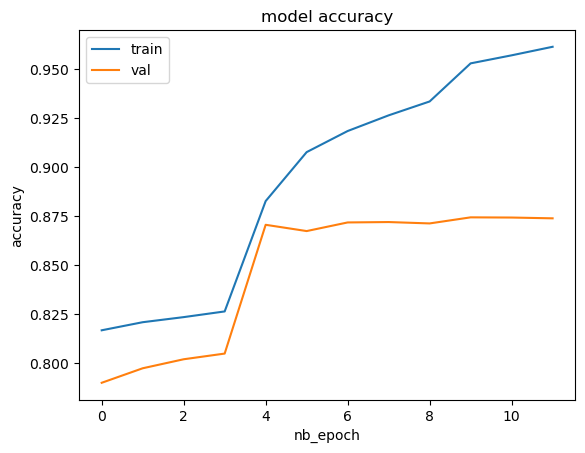

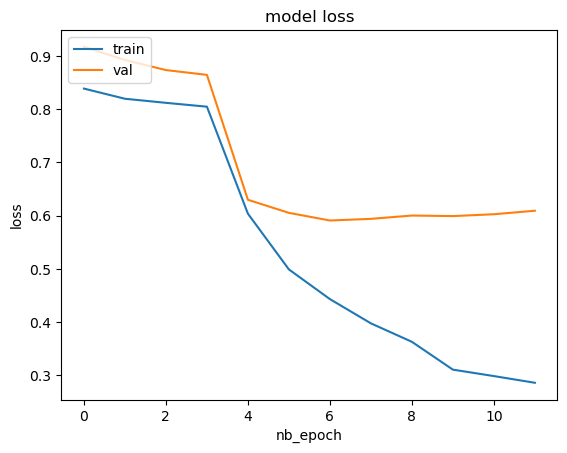

In [43]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('nb_epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('nb_epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
pred = model.predict(x_test)

313/313 [==============================] - 6s 15ms/step


In [45]:
import numpy as np


labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
errors = y_pred - y_true != 0

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1000
           1       0.94      0.95      0.94      1000
           2       0.83      0.83      0.83      1000
           3       0.77      0.75      0.76      1000
           4       0.86      0.88      0.87      1000
           5       0.81      0.80      0.80      1000
           6       0.91      0.90      0.90      1000
           7       0.90      0.90      0.90      1000
           8       0.94      0.91      0.92      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [47]:
scores = model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.6092 - accuracy: 0.8740


In [48]:
pred

array([[3.4614061e-12, 6.6122913e-11, 6.2652694e-10, ..., 3.7812292e-10,
        2.4633745e-11, 2.7488044e-12],
       [9.9145871e-07, 6.1406590e-06, 1.0852346e-13, ..., 2.7616494e-14,
        9.9999285e-01, 5.0668945e-09],
       [6.6022425e-05, 1.2279954e-02, 9.2153859e-06, ..., 2.0136315e-07,
        9.8755336e-01, 8.9571120e-05],
       ...,
       [2.2034714e-10, 5.7913369e-11, 3.3617829e-07, ..., 4.9825803e-07,
        1.3029249e-09, 6.3360685e-11],
       [2.8463104e-05, 9.9992263e-01, 1.4041966e-05, ..., 2.8370458e-08,
        3.5254043e-06, 5.7922066e-06],
       [3.0777131e-13, 1.8164146e-12, 5.1350478e-12, ..., 9.9999833e-01,
        4.9354249e-13, 1.2209936e-12]], dtype=float32)